In [1]:
import sys
import os


current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [8]:
from CNN import CNN
from dataloader import EmotionDataset
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
# Hyperparameter
max_epoch = 10
learning_rate = 0.001
output_dim = 15
device='cuda'

In [4]:

data_transform = transforms.Compose([
    transforms.Resize((350, 350)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = EmotionDataset(
    csv_file='../data/legend.csv',
    img_dir='../images',
    transform=data_transform
)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
model = CNN(output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# training
epoch_loss = []
epoch_acc = []
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
    for i, (images, labels) in enumerate(dataloader):
        images = torch.tensor(images).to(device)
        labels = torch.tensor(labels).to(device)

        # update
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # get stat
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_prediction += labels.size(0)

        correct_prediction += (predicted == labels).sum().item()

        if (i + 1) % 5 == 0:
            print(
                f"[Epoch {epoch+1}/{max_epoch}, Batch {i+1}/{len(dataloader)}] current Loss: {loss.item():.4f}")
    epoch_loss.append(running_loss/len(dataloader))
    epoch_acc.append(correct_prediction/total_prediction)

print("training Done")
torch.save(model.state_dict(), 'emotion_cnn_model.pth')

C:\Users\64698\AppData\Local\Temp\ipykernel_39772\1000765297.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).to(device)
C:\Users\64698\AppData\Local\Temp\ipykernel_39772\1000765297.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


[Epoch 1/10, Batch 5/428] current Loss: 1.9221
[Epoch 1/10, Batch 10/428] current Loss: 1.1844
[Epoch 1/10, Batch 15/428] current Loss: 1.3761
[Epoch 1/10, Batch 20/428] current Loss: 0.7548
[Epoch 1/10, Batch 25/428] current Loss: 0.9601
[Epoch 1/10, Batch 30/428] current Loss: 1.3754
[Epoch 1/10, Batch 35/428] current Loss: 0.8542
[Epoch 1/10, Batch 40/428] current Loss: 1.4395
[Epoch 1/10, Batch 45/428] current Loss: 1.0278
[Epoch 1/10, Batch 50/428] current Loss: 0.9241
[Epoch 1/10, Batch 55/428] current Loss: 0.7565
[Epoch 1/10, Batch 60/428] current Loss: 1.2356
[Epoch 1/10, Batch 65/428] current Loss: 0.9306
[Epoch 1/10, Batch 70/428] current Loss: 0.9736
[Epoch 1/10, Batch 75/428] current Loss: 1.0236
[Epoch 1/10, Batch 80/428] current Loss: 0.9964
[Epoch 1/10, Batch 85/428] current Loss: 1.0232
[Epoch 1/10, Batch 90/428] current Loss: 0.9069
[Epoch 1/10, Batch 95/428] current Loss: 1.3198
[Epoch 1/10, Batch 100/428] current Loss: 0.9225
[Epoch 1/10, Batch 105/428] current Loss

Text(0.5, 1.0, 'loss vs epoch')

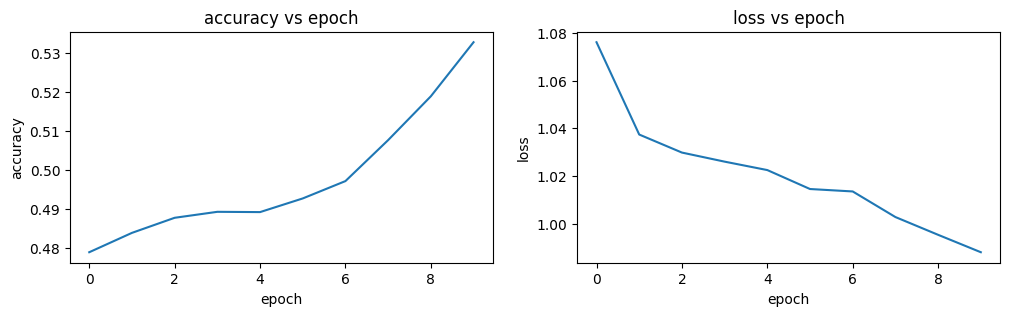

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].plot(range(len(epoch_acc)), epoch_acc)
axes[0].set_xlabel('epoch')
axes[0].set_ylabel("accuracy")
axes[0].set_title('accuracy vs epoch')

axes[1].plot(range(len(epoch_loss)), epoch_loss)
axes[1].set_xlabel('epoch')
axes[1].set_ylabel("loss")
axes[1].set_title('loss vs epoch')